# Visualize patched sphere simulations

In [458]:
%pwd

'/home/dkannan/git-remotes/protein_mobility'

In [459]:
import nglutils as ngu
import nglview as nv

import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp

import mdtraj
import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

In [460]:
slide_width = 11.5
half_slide_width = 5.67
aspect_ratio = 5/7
pres_params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.linewidth': 0.5,
                  'backend': 'ps',
                  'savefig.format': 'pdf',
                  'axes.titlesize': 20,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'xtick.labelsize': 16,
                  'ytick.labelsize': 16,
                  'text.usetex': False,
                  'figure.figsize': [half_slide_width, half_slide_width * aspect_ratio],
                  'font.family': 'sans-serif',
                   'font.size': 14,
                  #'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3,
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(pres_params)

In [461]:
def extract_trajectory(simdir, wrap=False, start=0, end=-1, every_other=10):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir.
    
    Parameters
    ----------
    simdir : str or Path
        path to simulation directory containing .h5 files
    start : int
        which time block to start loading conformations from
    end : int
        which time block to stop loading conformations from
    every_other : int
        skip every_other time steps when loading conformations
        
    Returns
    -------
    X : array_like (num_t, N, 3)
        x, y, z positions of all monomers over time
    
    """
    X = []
    data = list_URIs(simdir)
    #check if PBCbox was used
    initArgs = load_hdf5_file(Path(simdir)/"initArgs_0.h5")
    PBCbox = np.array(initArgs['PBCbox'])
    if PBCbox.any():
        boxsize = PBCbox
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir)/"starting_conformation_0.h5")['pos']
        X.append(starting_pos)
    for conformation in data[start:end:every_other]:
        pos = load_URI(conformation)['pos']
        if PBCbox.any() and wrap:
            mults = np.floor(pos / boxsize[None, :])
            pos = pos - mults * boxsize[None, :]
            assert pos.min() >= 0
        X.append(pos)
    X = np.array(X)
    return X

def patched_particle_geom(f, R=1):
    """ Distribute f residues on a sphere with equal angles."""
    
    #first position is center particle
    positions = [[0., 0., 0.]]
    theta = np.pi/2
    for i in range(min(f, 5)):
        #for valency less than 5, just distribute points on a circle in the x-y plane
        phi = 2 * np.pi * i / f
        x = R * np.sin(theta) * np.cos(phi)
        y = R * np.sin(theta) * np.sin(phi)
        z = R * np.cos(theta)
        positions.append([x, y, z])
    
    if f >=5:
        #octahedron -> put 5th particle perpendicular to plain of 4 points
        print("Have not implemented yet")
    return np.array(positions)

#make a topology for this f+1-atom chain
def mdtop_for_patched_particles(N, nchains, f, atom_names="XXX"):
    """
    Generate an mdtraj.Topology object for a single polymer of length N.

    Parameters
    ----------
    N : int
        total number of particles
    nchains : int
        number of tetramers
    f : int
        valency, i.e. number of patches
    atom_names : string (up to 3 characters) or list of such
        names for the atoms. This can be useful for labelling different types
        of monomers, such as compartments. If given as list, should have length
        N.

    Notes
    -----
        - use iron as element to prevent NGLView from calculating bonds
    """

    # Check that atom names are good
    if isinstance(atom_names, str):
        atom_names = [atom_names[:3] for _ in range(N)]
    elif not isinstance(atom_names, list) or not len(atom_names) == N:
        print("WARNING: atom_names should be a list of length N = {}. Using default." % N)
        atom_names = ["XXX" for _ in range(N)]

    # Generate topology
    top = mdtraj.Topology()
    resi = 0
    for i in range(nchains):
        ch = top.add_chain()
        res = top.add_residue("{0:03d}".format(resi // 10000), ch)
        first_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
        resi += 1
        for k in range(f):
            res = top.add_residue("{0:03d}".format(resi // 10000), ch)
            cur_atom = top.add_atom(atom_names[resi], mdtraj.element.iron, res)
            top.add_bond(first_atom, cur_atom)
            resi += 1
    return top


In [462]:
DATADIR = Path('/net/levsha/share/deepti/simulations/protein_mobility')

In [463]:
def make_animation(f, E0, N=1000, vol_fraction=0.3, r=None):
    if r:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}", 
                               wrap=False, start=0, end=1000, every_other=1)
    else:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=False, 
                           start=0, end=1000, every_other=1)
    print(Y.shape)
    X = Y[-1]
    print(X.shape)
    N = int(Y.shape[1]/(f+1))
    print(N)
    print(X.shape)
    atom_names = (['B'] + ['A']*f) * N
    top = mdtop_for_patched_particles((f+1)*N, N, f, atom_names=atom_names)
    view = ngu.xyz2nglview(X, top=top)
    view.add_representation('ball+stick', selection='.A',
                                                colorScheme='uniform',
                                                colorValue=0xff4242, radius=0.15)
    view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                            colorValue=0x475FD0, radius=0.35)
    view.add_unitcell()
    return view

In [292]:
view = make_animation(1, 7.0, r=0.25)
view

(1001, 2000, 3)
(2000, 3)
1000
(2000, 3)


NGLWidget()

## Test DBscan for clustering

In [464]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

def particles_from_mols(mol_ids, f):
    """ Return particle IDs (including patches) from list of molecule IDs"""
    particles = []
    for mol in mol_ids:
        particles += [mol + i for i in range(f + 1)]
    return particles

In [465]:
#def cluster_snapshot(f, E0, snapshot_ind, N=1000, vol_fraction=0.3):
f = 1
N = 1000
E0 = 7.0
vol_fraction = 0.3
Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=True, 
                           start=10000, every_other=100)
#indices of larger spheres
print(Y.shape)
molecule_inds = np.arange(0, (f+1)*N, f+1)
X = Y[-1, molecule_inds, :]
print(X.shape)

(100, 2000, 3)
(1000, 3)


In [298]:
distances = pdist(X)
print(len(distances[distances <= 1.1]))

434


In [447]:
for cutoff in np.arange(1.0, 1.1, 0.1):
    clustering = DBSCAN(eps=cutoff, min_samples=2).fit(X)
    unique_values, counts = np.unique(clustering.labels_, return_counts=True)
    if len(counts) > 1:
        print(f"Distance cutoff = {cutoff}, # clusters = {len(unique_values)-1}, max cluster size = {counts[1:].max()}")

Distance cutoff = 1.0, # clusters = 72, max cluster size = 6
Distance cutoff = 1.1, # clusters = 147, max cluster size = 61


In [448]:
for cluster in unique_values:
    mols_in_cluster = molecule_inds[clustering.labels_==cluster]
    particles = particles_from_mols(mols_in_cluster, 1)
    inter_cluster_distances = pdist(Y[-1, mols_in_cluster, :])
    if len(mols_in_cluster) >= 2:
        print(f"Cluster {cluster} with {len(mols_in_cluster)} molecules")

Cluster -1 with 182 molecules
Cluster 0 with 6 molecules
Cluster 1 with 2 molecules
Cluster 2 with 29 molecules
Cluster 3 with 4 molecules
Cluster 4 with 13 molecules
Cluster 5 with 2 molecules
Cluster 6 with 7 molecules
Cluster 7 with 4 molecules
Cluster 8 with 6 molecules
Cluster 9 with 61 molecules
Cluster 10 with 13 molecules
Cluster 11 with 5 molecules
Cluster 12 with 8 molecules
Cluster 13 with 8 molecules
Cluster 14 with 2 molecules
Cluster 15 with 2 molecules
Cluster 16 with 10 molecules
Cluster 17 with 6 molecules
Cluster 18 with 2 molecules
Cluster 19 with 2 molecules
Cluster 20 with 2 molecules
Cluster 21 with 32 molecules
Cluster 22 with 6 molecules
Cluster 23 with 3 molecules
Cluster 24 with 3 molecules
Cluster 25 with 7 molecules
Cluster 26 with 6 molecules
Cluster 27 with 3 molecules
Cluster 28 with 3 molecules
Cluster 29 with 4 molecules
Cluster 30 with 7 molecules
Cluster 31 with 13 molecules
Cluster 32 with 7 molecules
Cluster 33 with 8 molecules
Cluster 34 with 11 mo

In [456]:
mols_in_cluster = molecule_inds[clustering.labels_==3]
particles = particles_from_mols(mols_in_cluster, f)

In [457]:
cluster_size = len(mols_in_cluster)
atom_names = (['B'] + ['A']*f) * cluster_size
top = mdtop_for_patched_particles((f+1)*cluster_size, cluster_size, f, atom_names=atom_names)
view = ngu.xyz2nglview(Y[-1, particles, :], top=top)
view.add_representation('ball+stick', selection='.A',
                                            colorScheme='uniform',
                                            colorValue=0xff4242, radius=0.15)
view.add_representation('ball+stick', selection='.B', colorScheme='uniform',
                        colorValue=0xA2A2A2, radius=0.3)
view

NGLWidget()

In [289]:
def cluster_size_distribution(f, E0, N=1000, vol_fraction=0.3, r=None,
                              cutoff=1.2, wrap=False):
    if r:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}_r{r}", wrap=wrap, 
                               start=10000, every_other=100)
    else:
        Y = extract_trajectory(DATADIR/f"N{N}_f{f}_E0{E0}_v{vol_fraction}", wrap=wrap, 
                               start=10000, every_other=100)
    #indices of larger spheres
    molecule_inds = np.arange(0, (f+1)*N, f+1)
    cluster_sizes = []
    for i in range(Y.shape[0]):
        X = Y[i, molecule_inds, :]
        clustering = DBSCAN(eps=cutoff, min_samples=2).fit(X)
        cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
        #first element of counts represents number of monomers
        cluster_sizes += counts[0] * [1] + list(counts[1:])
    return cluster_sizes

In [288]:
import seaborn as sns

def plot_multimerization(f, cutoff=1.1, r=None):
    fig, ax = plt.subplots()
    E0_values = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
    colors = sns.color_palette("viridis", len(E0_values))
    for i, E0 in enumerate(E0_values):
        cluster_sizes = cluster_size_distribution(f, E0, cutoff=cutoff, r=r, wrap=True)
        counts, bins, patches = ax.hist(cluster_sizes, bins=np.arange(0, 1000, 1), density=True, 
                                        cumulative=True, histtype='step', color=colors[i], label=f'$E_0={E0}$')
    ax.set_xlabel('cluster size')
    ax.set_ylabel('CDF')
    ax.set_title(f'Multimerization landscape, f={f}, d={cutoff}')
    ax.set_xlim(0, 30)
    ax.legend(loc='lower right', fontsize=14)
    if r is None:
        r = 0.5
    plt.savefig(f'plots/multimerization_f{f}_cutoff{cutoff}_r{r}.pdf')

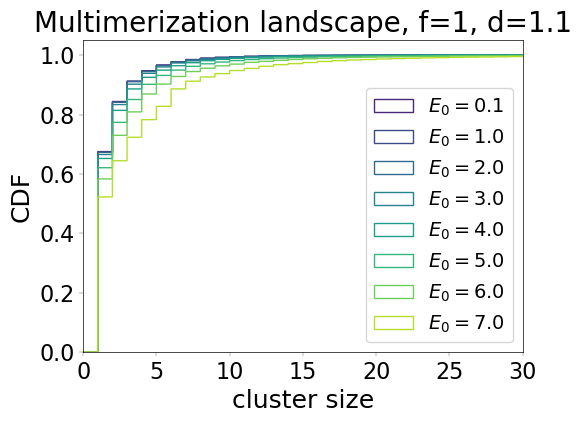

In [284]:
plot_multimerization(1, cutoff=1.1)

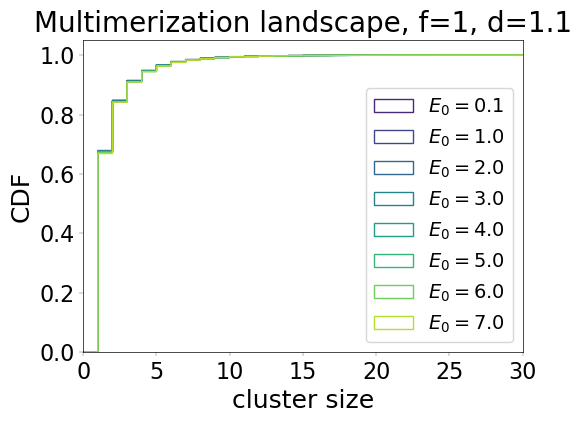

In [290]:
plot_multimerization(1, cutoff=1.1, r=0.25)

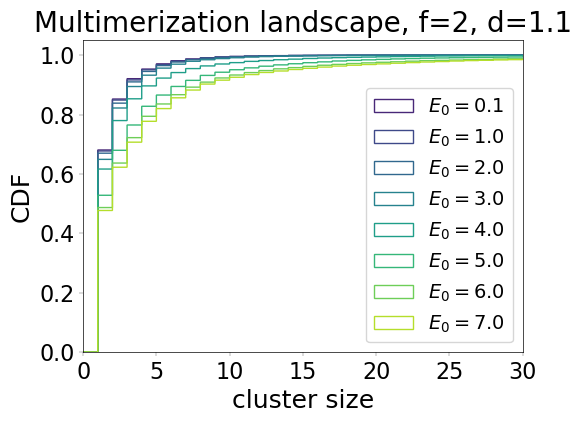

In [285]:
plot_multimerization(2, cutoff=1.1)

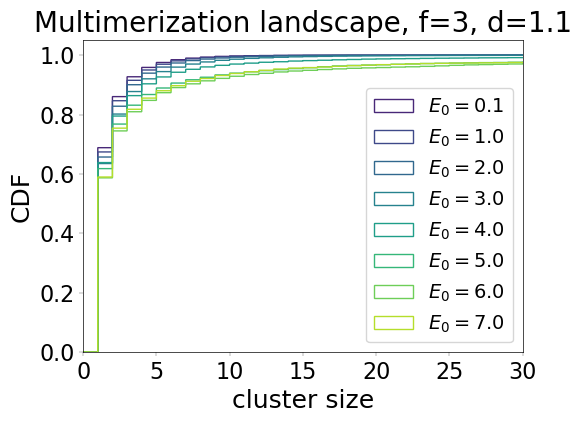

In [286]:
plot_multimerization(3, cutoff=1.1)

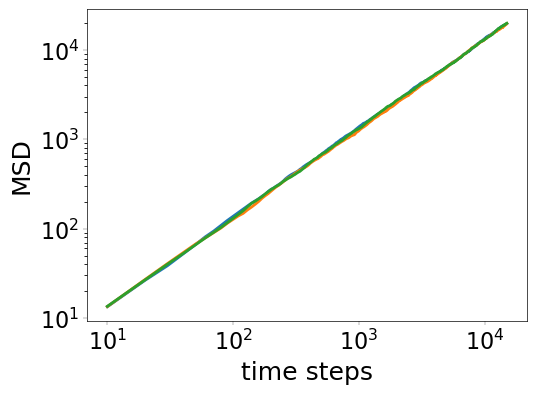

In [313]:
import pandas as pd

simdir = Path('/net/levsha/share/deepti/simulations/protein_mobility')
fig, ax = plt.subplots()
for E0 in [0.1, 6.0, 7.0]:
    path = simdir/f"N1000_f1_E0{E0}_v0.3_r0.25"
    msd_df = pd.read_csv(path/'sphere_msds_start5000_every_other_10.csv')
    ax.plot(msd_df['Time'].values[1:], msd_df['MSD'].values[1:], 
                        label=f"$E_0={E0}$")
ax.set_xlabel("time steps")
ax.set_ylabel("MSD")
ax.set_xscale("log")
ax.set_yscale("log")